# Model Selection And Validation

In this notebook, we will look at how you select a ML model for your data and also (more importantly), how do you evaluate the model performance. The main points why we evaluate the predictive performance of a model are as follows:

1. We want to estimate the generalization and predictive performance of our model on **future (unseen)** data.

2. We want to be able to improve the predictive performance by tweaking the learning algorithm and selecting the best performing model from a given hypothesis space.

3. We want to identify a model that its *best-suited* for the problem at hand; that is, we want to compare different algorithms, selecting the best-performing one as well as the best performing model from the model space.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Setup plot styles.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titlesize'] = 10

Let us take an example of a binary classification system using MNIST dataset. MNIST is a set of 70k small images of hand-written digits. Each image is labeled with the digit it represents. 

**Note:** Download the original MNIST data from [here](https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat). Save this data in `$HOME/scikit-learn-data/mldata` folder. Before you run the following code cell, check that you have the `mnist-original.mat` file in the above directory. (For Windows users, this will be something like 
*C:\\Users\\<user>\\scikit-learn-data\\mldata*).

In [3]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

Let's look at the data.

In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
uy, cy = np.unique(y, return_counts=True)
print(cy)
cy.sum()

[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


70000

There are 70k images, and each images has 784 features. We shall resize each image to 28x28 pixels. Let's visualize a few of the images.

In [6]:
# Plot helper. Visualize images with different labels in one plot
def plot_digits(images, images_per_row=10, **opts):
    size = 28
    images_per_row = min(len(images), images_per_row)
    images = [image.reshape(size,size) for image in images]
    n_rows = (len(images) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(images)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **opts)
    plt.axis("off")

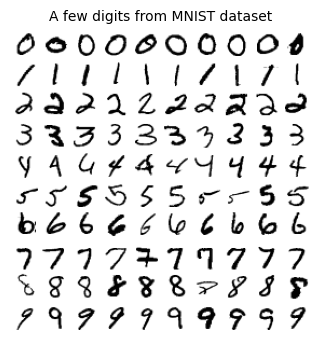

In [7]:
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.title('A few digits from MNIST dataset')
plt.show()

Looking at the data, hopefully you see the variability in the images. 

Let us now create a train and test sets.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We will also *shuffle* the dataset once before model training. This will guarantee that all cross-validation folds will be similar. Also, some learning algorithms are sensitive to the order of the training samples, and they perform poorly if they get many similar samples consecutively (e.g. neural networks with batch-size > 1).

In [9]:
np.random.seed(42)

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let us simplify the problem for now and only try to identify one digit - for example, the number 3. This "3-detector" is an example of a *binary classifier*, only capable of distinguishing between two classes, 3 and not-3. 

In [10]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

The `SGDClassifier` estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

In [11]:
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier

model = SGDClassifier(random_state=42, max_iter=100)
model.fit(X_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Once the model is trained, you can use it for prediction.

In [12]:
X_sample = X[np.random.randint(len(X))]
model.predict([X_sample])

array([False])

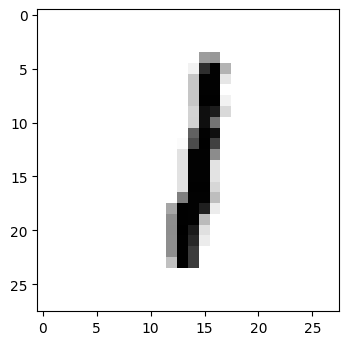

In [13]:
image = X_sample.reshape(28,28)

plt.imshow(image, cmap=plt.cm.binary)
plt.show()

## Fine-Tune Model and Performance Measure 

There are many performance measures available for a classifier. Let us look at some of these.

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use *cross-validation*. There are two ways you can do cross-validation with `sklearn`. Let us look at the simpler one first.

#### `cross_val_score`

In the first example, we will use `cross_val_score()` function to evaluate the `SGDClassifier` model using K-fold cross-validation, with three folds. K-fold cross-validation means splitting the training set into K-folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds. (Look at `Decision Trees` notebook for more details)

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.96410179, 0.9258    , 0.95949797])

Let us compute the `null accuracy` as well to check if this is better than a prediction where we classify every image as *not-3*.

In [15]:
cls, counts = np.unique(y_train_3, return_counts=True)

cls,counts

(array([False,  True]), array([53869,  6131]))

In [16]:
print(f'Null accuracy: {counts[0] / (counts.sum())}')

Null accuracy: 0.8978166666666667


Therefore, with just a random guess, we achieve around 90% accuracy. This is just because the positive class only occurs in 10% of the images. This is a classic example of **imbalanced data distribution**. To counter the data imbalance, you can set the `class_weight='balanced'` hyper-parameter in some estimators. 

#### `StratifiedKFold`

You may also try a more customizable version of K-Fold cross-validation. In the following example, we see how to use `StratifiedKFold` based cross-validation. In Stratified K-Fold cross-validation, the validator makes sure that training dataset in each fold contains an even distribution of positive/negative cases. In this way the model learns to predict both classes without any bias.

In [18]:
from sklearn.model_selection import StratifiedKFold
# clone the model parameters each time to keep the original model intact. Note: this model is NOT a numpy.ndarray. Check type(model)
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=2, random_state=42)
accuracies = []

for train_idx, test_idx in skfolds.split(X_train, y_train_3):
    model_clone = clone(model)
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = X_train[train_idx], X_train[test_idx], y_train[train_idx], y_train[test_idx]
    
    model_clone.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_clone.predict(X_val_fold)
    n_correct = sum(y_pred_fold == y_val_fold)
    accuracies.append(1.0 * n_correct / len(y_pred_fold))
    
print(accuracies)
print('Mean accuracy {:.2f}'.format(np.sum(accuracies) / len(accuracies)))

[0.8509383020565982, 0.8792626420880696]
Mean accuracy 0.87


#### `GridSearchCV`

Another way to fine-tune a model is to use *grid search* based cross-validation over its hyper-parameters. 

One way to do that would be to fiddle around with the hyper-parameters manually, until you find a great combination of hyper-parameter values. This would be arduous and you may not have time to explore ALL combinations.

In these cases, you should use `sklearn.GridSearchCV` to search an optimal model for you. You need to specify which hyper-parameters you want to experiment with, and what values to try out. The `GridSearchCV` function will evaluate all the possible combinations of the hyper-parameter values, using cross-validation. 

In [19]:
model

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

The possible options for `loss` hyper-parameter are [`hinge`](https://en.wikipedia.org/wiki/Hinge_loss), `log`, `squared_hinge`, [`modified_huber`](https://en.wikipedia.org/wiki/Huber_loss). The options for `penalty` are `l2` (squared difference) or `l1` (absolute difference). More details [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). 

We can do a GridSearch to find the best loss and penalty.

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber']},
    {'penalty': ['l2', 'l1']}
]

CV = GridSearchCV(SGDClassifier(), 
                 param_grid,
                 cv=3,
                 scoring='roc_auc',
                 return_train_score=True,
                 verbose=10,
                 n_jobs=-1)
CV.fit(X_train, y_train_3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] loss=hinge ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=hinge ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=hinge ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model

[CV] loss=log ........................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=log ........................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=log ........................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=squared_hinge ..............................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=squared_hinge ..............................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ............. loss=hinge, score=0.9693994743040752, total=   0.7s
[CV] loss=squared_hinge ..............................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ............. loss=hinge, score=0.9718019128297526, total=   0.7s
[CV] loss=modified_huber .............................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] ............. loss=hinge, score=0.9498609861251089, total=   0.8s
[CV] loss=modified_huber .............................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s


[CV] ............... loss=log, score=0.9713155813512755, total=   0.8s


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] loss=modified_huber .............................................
[CV] ............... loss=log, score=0.9649397646955225, total=   0.8s


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] penalty=l2 ......................................................[CV] ............... loss=log, score=0.9618533453232663, total=   0.8s



/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] penalty=l2 ......................................................
[CV] ..... loss=squared_hinge, score=0.9696058272278405, total=   0.8s

[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    1.5s remaining:    4.0s



[CV] ...... loss=squared_hinge, score=0.965726123740616, total=   0.8s

/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



[CV] penalty=l2 ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] penalty=l1 ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    1.7s remaining:    2.7s


[CV] ..... loss=squared_hinge, score=0.9620296614544914, total=   0.8s
[CV] penalty=l1 ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .... loss=modified_huber, score=0.9706970402332077, total=   0.9s


[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    2.2s remaining:    2.2s


[CV] penalty=l1 ......................................................


/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV] .... loss=modified_huber, score=0.9624976132132514, total=   0.9s
[CV] .... loss=modified_huber, score=0.9649164155770122, total=   0.9s
[CV] ............. penalty=l2, score=0.9707929695498934, total=   0.9s
[CV] ............. penalty=l2, score=0.9583086934838323, total=   0.8s


[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.7s remaining:    1.0s


[CV] ............. penalty=l2, score=0.9643542102754687, total=   0.8s


[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    2.8s remaining:    0.6s


[CV] ............. penalty=l1, score=0.9654308994513638, total=   1.2s
[CV] ............. penalty=l1, score=0.9663531184513221, total=   1.2s
[CV] ............. penalty=l1, score=0.9658541240801057, total=   1.1s


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.6s finished
/Users/prateepmukherjee/Documents/Projects/turi/mjolnir-cli/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber']}, {'penalty': ['l2', 'l1']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=10)

**Note:** When you have no idea what value a hyper-parameter should have, a simple approach is to try out consecutive powers of 10 for a smaller number.

In [35]:
CV.best_params_

{'loss': 'modified_huber'}

In [36]:
CV.best_estimator_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [37]:
CV.best_score_

0.9660371193515681

In [38]:
CVres = CV.cv_results_

for mean_test_score, params in zip(CVres['mean_test_score'], CVres['params']):
    print(mean_test_score, params)

0.9636877833944487 {'loss': 'hinge'}
0.9660363881606218 {'loss': 'log'}
0.9657873304104122 {'loss': 'squared_hinge'}
0.9660371193515681 {'loss': 'modified_huber'}
0.9644853984157193 {'penalty': 'l2'}
0.9658793736071868 {'penalty': 'l1'}


### Confusion Matrix

To evaluate a classifier performance we can also look at the *confusion matrix*, a truth table which counts how many samples were predicted correct/incorrect. To compute the confusion matrix, you first need a set of predictions, so they can be compared to the actual targets. Let us check the confusion matrix on the train dataset first.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(model, X_train, y_train_3, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3, y_train_pred)

We will now define some metrics that can be seen in the above matrix.